This notebook tests the idea that the steady-state distribution of Langevin dynamics
$$dx = \text{diffuse}(x)dt + \sqrt{2\beta}dW_t$$
is given by the Gibbs distribution with the corresponding potential $V(x)$ given by
$$\frac{dV(x)}{dx} = -\text{diffuse}(x)$$

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def derivative_func(x, r, **kwargs):
    return r*x - x**3

drift_func = derivative_func

def euler_increment(x, derivative_func, dt=0.1, **deriv_params):
    dxdt = derivative_func(x, **deriv_params)
    return dxdt * dt

def diffuse_func(x, beta=0.5, **kwargs):
    if len(np.shape(x)) > 0:
        xi = np.random.randn(*np.shape(x))
    else:
        xi = np.random.randn()
    return np.sqrt(2*beta)*xi

def euler_maruyama_increment(x, drift_func, diffuse_func, dt=0.1, **deriv_params):
    dt_coeff = drift_func(x, **deriv_params)
    dw_coeff = diffuse_func(x, **deriv_params)
    return dt_coeff * dt + dw_coeff * np.sqrt(dt)

def potential_func(x, r, **potential_func_params):
    return -0.5 * r * x**2 + 0.25 * x**4

def Gibbs_dist(x, potential_func, beta, **potential_func_params):
    return np.exp(-potential_func(x, **potential_func_params)/beta)

In [50]:
Gibbs_dist(x, **deriv_params).shape, x.shape

((100,), (100,))

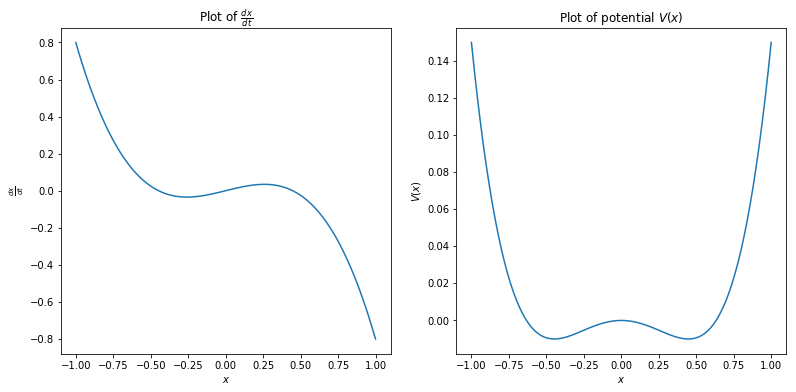

In [120]:
x = np.linspace(-1, 1, 100)
r = 0.2

dxdt = derivative_func(x, r=r)
Vx = potential_func(x, r=r)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].plot(x, dxdt)
axes[0].set_title(r'Plot of $\frac{dx}{dt}$')
axes[0].set_ylabel(r'$\frac{dx}{dt}$')
axes[0].set_xlabel(r'$x$')

axes[1].plot(x, Vx)
axes[1].set_title(r'Plot of potential $V(x)$')
axes[1].set_ylabel(r'$V(x)$')
axes[1].set_xlabel(r'$x$')

plt.savefig('derivatives.png')
plt.show()

In [98]:
def run_sim(x_0, total_steps, increment_func, **deriv_params):
    if len(np.shape(x_0)) > 0:
        shape = (np.shape(x_0)[0], total_steps)
    else:
        shape = (1, total_steps)
    x_trace = np.zeros(shape=shape)
    x_trace[:, 0] = x_0
    for t in range(total_steps-1):
        x_new = increment_func(x_trace[:, t], **deriv_params)
        x_trace[:, t+1] = x_trace[:, t] + x_new
    return x_trace

In [112]:
total_steps = 10000
num_random_traces = 10000
x_0 = 0.25
deriv_params = {
    'r': r,
    'beta': 0.05,
    'dt': 0.1,
    'total_steps': total_steps,
    'derivative_func': derivative_func,
    'drift_func': drift_func,
    'diffuse_func': diffuse_func,
    'potential_func': potential_func,
    'num_random_traces': num_random_traces
}

In [113]:
det_trace = run_sim(x_0, increment_func=euler_increment, **deriv_params)
rand_trace = run_sim(x_0, increment_func=euler_maruyama_increment, **deriv_params)

In [114]:
x_0 = np.random.rand(num_random_traces)*2-1
random_traces = run_sim(x_0, increment_func=euler_maruyama_increment, **deriv_params)

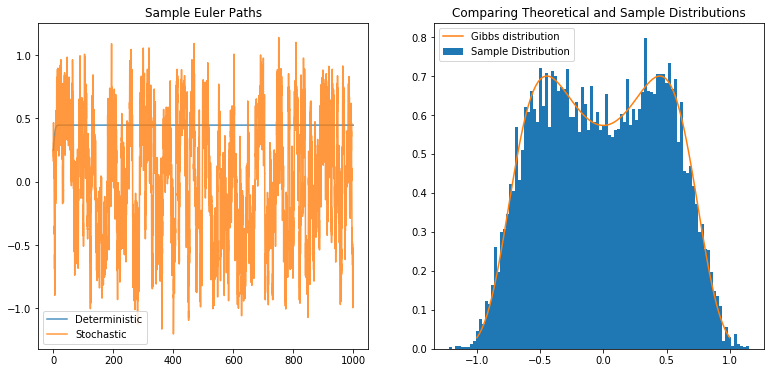

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))
axes[0].plot(
    np.arange(total_steps)*deriv_params['dt'],
    det_trace.squeeze(),
    label='Deterministic',
    alpha=0.8
)
axes[0].plot(
    np.arange(total_steps)*deriv_params['dt'],
    rand_trace.squeeze(),
    label='Stochastic',
    alpha=0.8
)
axes[0].legend()
axes[0].set_title('Sample Euler Paths')

formal_distribution = Gibbs_dist(x, **deriv_params)
formal_distribution = formal_distribution / (formal_distribution[1:] * np.diff(x)).sum()
axes[1].hist(
    random_traces[:, -1],
    bins=max(int(np.sqrt(num_random_traces)), 50),
    density=True,
    label='Sample Distribution'
)
axes[1].plot(x, formal_distribution, label='Gibbs distribution')
axes[1].legend()
axes[1].set_title('Comparing Theoretical and Sample Distributions')

plt.savefig('samples.png')
plt.show()